In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TF Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

In [3]:
df = pd.read_csv("/content/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
X = df["comment_text"]
y = df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]

In [5]:
MAX_FEATURES = 50000
SEQ_LEN = 300

vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode="int",
    output_sequence_length=SEQ_LEN
)

vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)


In [6]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(100000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)

train = dataset.take(int(len(dataset)*0.7))
val   = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test  = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [7]:
model = Sequential()

model.add(Embedding(MAX_FEATURES + 1, 32, input_length=SEQ_LEN))

model.add(Bidirectional(
    LSTM(32, activation='tanh', dropout=0.3)
))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.4))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(6, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
history = model.fit(train, epochs=5, validation_data=val)
model.summary()

Epoch 1/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 113s 30ms/step - accuracy: 0.8377 - loss: 0.1014 - val_accuracy: 0.9940 - val_loss: 0.0484
Epoch 2/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9925 - loss: 0.0499 - val_accuracy: 0.9940 - val_loss: 0.0456
Epoch 3/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 91s 26ms/step - accuracy: 0.9850 - loss: 0.0469 - val_accuracy: 0.9942 - val_loss: 0.0414
Epoch 4/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 92s 26ms/step - accuracy: 0.9530 - loss: 0.0432 - val_accuracy: 0.9943 - val_loss: 0.0405
Epoch 5/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 91s 26ms/step - accuracy: 0.9817 - loss: 0.0418 - val_accuracy: 0.9947 - val_loss: 0.0372


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 32)        │     1,600,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,075,060 (19.36 MB)

 Trainable params: 1,691,686 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,383,374 (12.91 MB)

<Figure size 800x500 with 0 Axes>

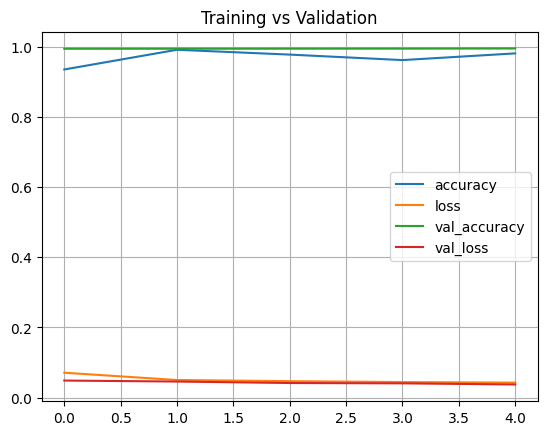

In [9]:
import pandas as pd
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.title("Training vs Validation")
plt.grid()
plt.show()


In [10]:
def classify(text):
    encoded = vectorizer([text])  # Convert to batch input
    pred = model.predict(encoded)[0]
    return pred, (pred > 0.5).astype(int)

text = "You freaking suck! I am going to hit you."
probabilities, label = classify(text)

print("Raw probabilities:", probabilities)
print("Binary prediction:", label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Raw probabilities: [0.9981213  0.21712343 0.94342744 0.05742788 0.81545496 0.1816182 ]
Binary prediction: [1 0 1 0 1 0]


In [11]:
batch_X, batch_y = test.as_numpy_iterator().next()

preds = model.predict(batch_X)

binary_preds = (preds > 0.5).astype(int)

print("Batch shape:", batch_X.shape)
print("Pred shape:", binary_preds.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Batch shape: (32, 300)
Pred shape: (32, 6)


In [14]:
import tensorflow as tf

pre = tf.keras.metrics.Precision()
re  = tf.keras.metrics.Recall()
acc = tf.keras.metrics.BinaryAccuracy()


In [15]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

In [16]:
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall:    {re.result().numpy():.4f}")
print(f"Accuracy:  {acc.result().numpy():.4f}")

Precision: 0.8611
Recall:    0.7159
Accuracy:  0.9851


In [17]:
!pip install gradio jinja2

In [18]:
import tensorflow as tf
import gradio as gr
import numpy as np

In [19]:
model.save('toxicity.h5')

In [20]:
model = tf.keras.models.load_model("toxicity.h5")

In [21]:
input_str = vectorizer(['You are a disgrace and a waste of space.'])
res = model.predict(input_str)
print(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
[[0.72413677 0.00310681 0.16596441 0.01876839 0.2350109  0.04324847]]


In [22]:
# Scoring function
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ""
    for idx, col in enumerate(df.columns[2:]):
        text += "{}: {}\n".format(col, results[0][idx] > 0.5)

    return text

# UI
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder="Comment to score"),
    outputs="text"
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a1d6f709c96f10c21d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
def predict_comment_dict(text):

    vectorized = vectorizer([text])


    probs = model.predict(vectorized)[0]


    preds = (probs > 0.5).astype(int)


    labels = [
        "toxic",
        "severe_toxic",
        "obscene",
        "threat",
        "insult",
        "identity_hate"
    ]


    return dict(zip(labels, preds))


In [24]:
text = "You are a disgrace and a waste of space."
output = predict_comment_dict(text)

print(output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
{'toxic': np.int64(1), 'severe_toxic': np.int64(0), 'obscene': np.int64(0), 'threat': np.int64(0), 'insult': np.int64(0), 'identity_hate': np.int64(0)}


In [25]:
predict_comment_dict("I respect your opinion.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


{'toxic': np.int64(0),
 'severe_toxic': np.int64(0),
 'obscene': np.int64(0),
 'threat': np.int64(0),
 'insult': np.int64(0),
 'identity_hate': np.int64(0)}